In [1]:
!pip install scvi-tools

In [2]:
import sys

#if branch is stable, will install via pypi, else will install from source
branch = "stable"
IN_COLAB = "google.colab" in sys.modules

if IN_COLAB and branch == "stable":
    !pip install --quiet scvi-tools[tutorials]
elif IN_COLAB and branch != "stable":
    !pip install --quiet --upgrade jsonschema
    !pip install --quiet git+https://github.com/yoseflab/scvi-tools@$branch#egg=scvi-tools[tutorials]

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import scvi
import scanpy as sc
import tensorflow as tf

sc.set_figure_params(figsize=(4, 4))

Global seed set to 0
/usr/local/lib/python3.7/dist-packages/numba/np/ufunc/parallel.py:363: NumbaWarning: The TBB threading layer requires TBB version 2019.5 or later i.e., TBB_INTERFACE_VERSION >= 11005. Found TBB_INTERFACE_VERSION = 9107. The TBB threading layer is disabled.
  warnings.warn(problem)


In [4]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [5]:
import os
os.listdir('/content/drive/MyDrive/UMINTv2/Data/preprocessedData/pbmc10k_MALT/')

['pbmc10k_MALT_rna_scaled.csv',
 'pbmc10k_MALT_rna.h5Seurat',
 'pbmc10k_MALT_rna.h5ad',
 'pbmc10k_MALT_adt_scaled.csv',
 'pbmc10k_MALT_adt.h5Seurat',
 'pbmc10k_MALT_adt.h5ad']

In [6]:
dir = '/content/drive/MyDrive/UMINTv2/Data/preprocessedData/pbmc10k_MALT/'
dir1 = '/content/drive/MyDrive/UMINTv2/Labels/pbmc10k_MALT/'

In [7]:
pbmc_rna = sc.read(dir+'pbmc10k_MALT_rna.h5ad')
pbmc_rna

AnnData object with n_obs × n_vars = 8412 × 2000
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA'
    var: 'vst.mean', 'vst.variance', 'vst.variance.expected', 'vst.variance.standardized', 'vst.variable'

In [8]:
pbmc_adt = sc.read(dir+'pbmc10k_MALT_adt.h5ad')
pbmc_adt

AnnData object with n_obs × n_vars = 8412 × 17
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA'
    var: 'features'

In [9]:
pbmc_rna.var.head()

,vst.mean,vst.variance,vst.variance.expected,vst.variance.standardized,vst.variable
HES4,0.184974,0.973984,0.335877,2.899822,1
ISG15,0.621255,2.941781,1.943976,1.513280,1
RNF223,0.001783,0.003920,0.002262,1.733146,1
TNFRSF18,0.197337,0.975439,0.366333,2.662709,1
TNFRSF4,0.196743,0.842396,0.364846,2.308907,1


In [10]:
temp_rna = pbmc_rna.X
temp_adt = pbmc_adt.X

In [11]:
from sklearn.preprocessing import MinMaxScaler
scaler= MinMaxScaler()
temp_rna = scaler.fit_transform(temp_rna)
temp_adt = scaler.fit_transform(temp_adt)

In [12]:
# scvi needs one adata, so we merge rna and cite
adata = pbmc_rna
adata.layers["counts"] = temp_rna
adata.obsm['proteins'] = temp_adt

In [13]:
adata

AnnData object with n_obs × n_vars = 8412 × 2000
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA'
    var: 'vst.mean', 'vst.variance', 'vst.variance.expected', 'vst.variance.standardized', 'vst.variable'
    obsm: 'proteins'
    layers: 'counts'

In [14]:
scvi.data.setup_anndata(adata, layer="counts", protein_expression_obsm_key='proteins')

INFO     No batch_key inputted, assuming all cells are same batch                            
INFO     No label_key inputted, assuming all cells have same label                           
INFO     Using data from adata.layers["counts"]                                              
INFO     Using protein expression from adata.obsm['proteins']                                
INFO     Generating sequential protein names                                                 
INFO     Successfully registered anndata object containing 8412 cells, 2000 vars, 1 batches, 
         1 labels, and 17 proteins. Also registered 0 extra categorical covariates and 0     
         extra continuous covariates.                                                        
INFO     Please do not further modify adata until model is trained.                          


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function setup_anndata is deprecated; Please use the model-specific setup_anndata methods instead. The global method will be removed in version 0.15.0.
  warnings.warn(msg, category=FutureWarning)


In [15]:
vae = scvi.model.TOTALVI(adata)

INFO     Computing empirical prior initialization for protein background.                    


/usr/local/lib/python3.7/dist-packages/scvi/model/base/_base_model.py:151: UserWarning: Make sure the registered X field in anndata contains unnormalized count data.
  "Make sure the registered X field in anndata contains unnormalized count data."
/usr/local/lib/python3.7/dist-packages/scvi/model/_totalvi.py:1041: UserWarning: Make sure the registered protein expression in anndata contains unnormalized count data.
  "Make sure the registered protein expression in anndata contains unnormalized count data."


In [16]:
with tf.device('/GPU:0'):
  vae.train()

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 1/400:   0%|          | 0/400 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/scvi/distributions/_negative_binomial.py:533: UserWarning: The value argument must be within the support of the distribution
  UserWarning,


Epoch 400/400: 100%|██████████| 400/400 [07:50<00:00,  1.18s/it, loss=199, v_num=1]


In [17]:
adata.obsm["X_totalVI"] = vae.get_latent_representation()

/usr/local/lib/python3.7/dist-packages/scvi/model/base/_base_model.py:151: UserWarning: Make sure the registered X field in anndata contains unnormalized count data.
  "Make sure the registered X field in anndata contains unnormalized count data."
/usr/local/lib/python3.7/dist-packages/scvi/model/_totalvi.py:1041: UserWarning: Make sure the registered protein expression in anndata contains unnormalized count data.
  "Make sure the registered protein expression in anndata contains unnormalized count data."


In [18]:
sc.pp.neighbors(adata, use_rep="X_totalVI")
sc.tl.umap(adata, min_dist=0.4)
sc.tl.leiden(adata, key_added="leiden_totalVI")

/usr/local/lib/python3.7/dist-packages/numba/core/ir_utils.py:1525: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  if (hasattr(numpy, value)
/usr/local/lib/python3.7/dist-packages/numba/core/ir_utils.py:1526: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  and def_val == getattr(numpy, value)):
/usr/local/lib/python3.7/dist-packages/numba/co

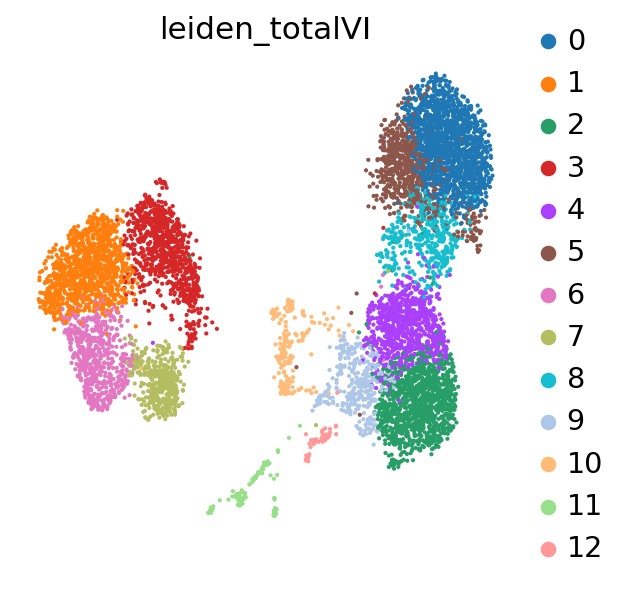

In [19]:
sc.pl.umap(
    adata,
    color=["leiden_totalVI"],
    frameon=False,
    ncols=1,
)

In [20]:
adata.obs

,orig.ident,nCount_RNA,nFeature_RNA,_scvi_batch,_scvi_labels,leiden_totalVI
AAACCCAAGAGGCGGA-1,0,2467.0,881,0,0,0
AAACCCAAGCGCCTTG-1,0,3947.0,1153,0,0,4
AAACCCAAGTCTGCAT-1,0,3443.0,980,0,0,1
AAACCCACACCATAAC-1,0,3780.0,990,0,0,1
AAACCCAGTCTCTCCA-1,0,3928.0,1428,0,0,6
...,...,...,...,...,...,...
TTTGTTGCATATGGCT-1,0,2519.0,908,0,0,0
TTTGTTGGTAGTTCCA-1,0,4031.0,1152,0,0,0
TTTGTTGTCCTCACGT-1,0,2650.0,1078,0,0,0
TTTGTTGTCGCTCTCA-1,0,3313.0,1086,0,0,8


In [21]:
pbmc10k_MALT_labels_totalVI = adata.obs['leiden_totalVI']

In [22]:
pbmc10k_MALT_labels_totalVI.to_csv(dir1+'pbmc10k_MALT_labels_totalVI.csv')